In [ ]:
!pip install -q transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.3 MB/s eta 0:00:00


In [1]:
import os
import zipfile
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from tqdm.auto import tqdm
from google.colab import drive
import numpy as np

In [2]:
zip_path = '/content/drive/MyDrive/sentiment analysis.zip'  # Update if needed
extract_path = '/content/sentiment_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

['test.csv',
 'testdata.manual.2009.06.14.csv',
 'training.1600000.processed.noemoticon.csv',
 'train.csv']

In [3]:
df_train = pd.read_csv(f"{extract_path}/train.csv", encoding="latin1")
df_test = pd.read_csv(f"{extract_path}/test.csv", encoding="latin1")

df_train = df_train[['text', 'sentiment']].dropna()
df_test = df_test[['text', 'sentiment']].dropna()

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df_train['label'] = df_train['sentiment'].map(label_map)
df_test['label'] = df_test['sentiment'].map(label_map)


In [10]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # remove batch dim
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }



In [14]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

model.to(device)

Using device: cuda


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [12]:
train_dataset = SentimentDataset(df_train['text'].tolist(), df_train['label'].tolist(), tokenizer)
test_dataset = SentimentDataset(df_test['text'].tolist(), df_test['label'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [19]:
epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * epochs

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

loss_per_epoch = []
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_per_epoch.append(avg_loss)
    print(f"\nEpoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}")


  0%|          | 0/17175 [00:00<?, ?it/s]


Epoch 1/5 - Average Loss: 0.5647

Epoch 2/5 - Average Loss: 0.4168

Epoch 3/5 - Average Loss: 0.3135

Epoch 4/5 - Average Loss: 0.2147

Epoch 5/5 - Average Loss: 0.1487



Classification Report:

              precision    recall  f1-score   support

    negative       0.78      0.81      0.79      1001
     neutral       0.77      0.74      0.76      1430
    positive       0.84      0.85      0.84      1103

    accuracy                           0.79      3534
   macro avg       0.80      0.80      0.80      3534
weighted avg       0.79      0.79      0.79      3534



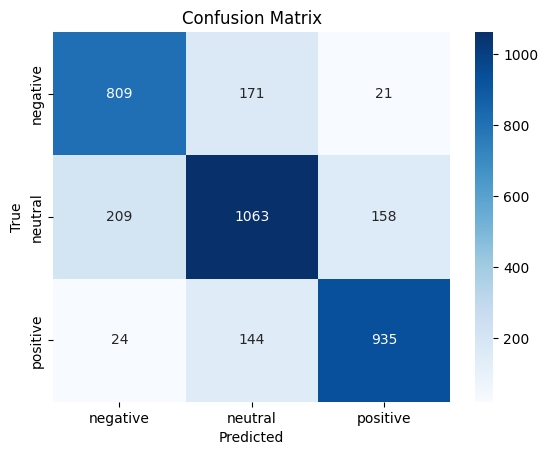

In [20]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()